# Tutorial 6: Quantifying variation in subcellular protein localization (GW-OT)

To demonstrate the functionality of GW-OT, we will perform an analysis on immunoflourescence data from the Human Protein Atlas. We will working with a small subset of 373 cells from 70 images, which can be downloaded from this [link](https://www.dropbox.com/scl/fi/63tquyl5b6psiczrgihdn/hpa_images_metadata.zip?rlkey=7iz9cl5u35bvfupip6f0iicf3&st=ocpnazb7&dl=0).

First, we will process the cell images, sample points from the cell boundary for morphological analysis and storing the subcellular protein information for localization analysis. We assume that cell segmentation has been performed on each image. Nuclear segmentation is optional, but can improve compartmental specificity in the localization analysis. 

The processed `GW_OT cell` objects can be kept in memory for faster analysis, or be written to files in cases where avaliable memory is insufficient. All functions that take `GW_OT cell` objects as input, can also take in the paths to the saved `GW_OT cell` objects.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import skimage as ski
from cajal.subcellular import *

In [ ]:
# change to path to where data is located
data_path = '/home/jovyan/e/rkhu/Projects/CAJAL_spatial/data/package_dev/test_analysis_2/'

# load image metadata
image_metadata = pd.read_csv(os.path.join(data_path, 'image_metadata.csv'), index_col=0)

In [ ]:
# create list to store cell objects
cell_objects = []
cell_metadata = pd.DataFrame(columns=image_metadata.columns)
for i in tqdm(range(image_metadata.shape[0])):
    im_path = os.path.join(data_path, 'images', image_metadata.iloc[i]['image_file'])
    # load image
    im = ski.io.imread(im_path)
    channels = ['microtubules', 'protein', 'DNA'] # names of channels in image
    # load cell and nuclear segmentation masks
    im_cell_mask = ski.io.imread(im_path.replace('blue_red_green.jpg','predictedmask.png'))
    im_nuc_mask = ski.io.imread(im_path.replace('blue_red_green.jpg','predictednucmask.png'))
    # create cell objects from image
    image_cell_objects = process_image(im, channels, im_cell_mask, im_nuc_mask, ds_target_size=1000)
    cell_objects.extend(image_cell_objects)
    # save metadata for each cell
    n_image_cells = len(image_cell_objects)
    cell_metadata = pd.concat([cell_metadata, image_metadata.iloc[i:i+1].reset_index(drop=True).loc[np.repeat(0, n_image_cells)]], ignore_index=True)

100%|██████████| 60/60 [05:51<00:00,  5.86s/it]


To capture the morphological variation between cells, we compute the Gromov-Wasserstein distance between each pair of cells, using points sampled from each cell boundary.

In [ ]:
# gw_dmat = gw_pairwise_parallel(cell_object_paths, num_processes=cpu_count(), chunksize=20)
gw_dmat = gw_pairwise_parallel(cell_objects, num_processes=cpu_count(), chunksize=20) 

100%|██████████| 69378/69378 [30:15<00:00, 38.22it/s] 


We can the cluster the cells based on the computed Gromov-Wasserstein morphology space to identify groups of cells that display similar morphologies. We can also use UMAP to embed the morphology space into 2 dimensions for visualization.

Cells in the same cluster should have similar morphologies. For example, we can visualize some cells from cluster 1.

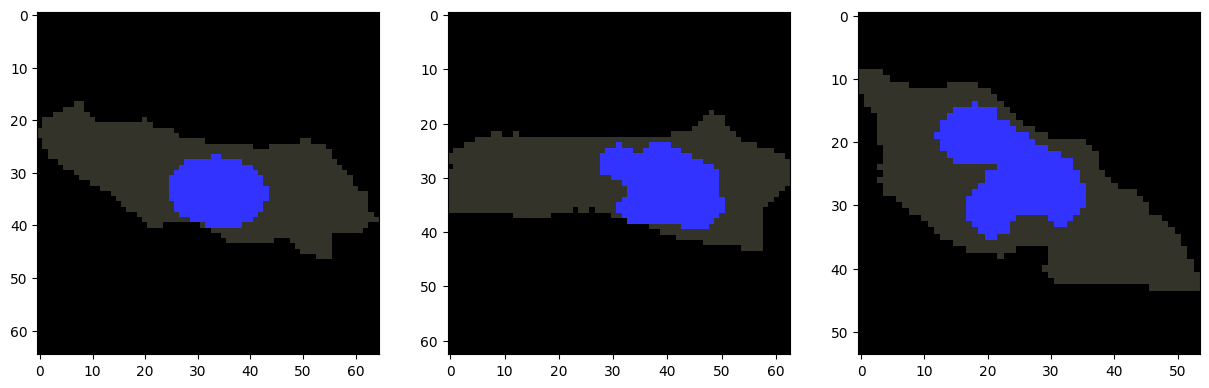

: 

In [ ]:
cells_to_plot = [122, 177, 188] # Example cells from cluster 1
fig, axes = plt.subplots(1, len(cells_to_plot), figsize=(15, 5))
for ax, i in zip(axes, cells_to_plot):
    plot_cell_image(cell_objects[i], channels=['nucleus'], ax=ax)
plt.show()

Before we quantify the variation in subcellular localization patterns, we must first map the protein localization patterns of each cell to an anchor cell. We recommend choosing centroid cell in in the morphology space, the most morphologically 'average' cell, as the anchor.

There are two approaches for mapping to the anchor cell: Fused Gromov-Wasserstein and Fused Unbalanced Gromov-Wasserstein. Fused Gromov-Wasserstein performs a full cell to cell mapping, which is appropriate for datasets with relatively simple cell morphologies. Fused Unbalanced Gromov-Wasserstein allows for partial cell to cell mappings. This is useful in datasets with more complex cell morphologies (i.e neurons) where certain cell structures may be present in one cell, but missing in others.

The "Fused" variant of Gromov-Wasserstein enables the mappings between cells to consider additional staining or segmentation information. By default, we choose the segmented nucleus mask to inform to mapping to better align cellular structures, but other stains can be used as well. The `fused_cost` and `fused_param` parameters control how much this additional information is considered in the mapping. Higher values of `fused_cost` and lower values of `fused_param` give greater weight to this additional information. In practive we've found the cell mappings to be more sensitive to changes in the `fused_cost` value, as opposed to the `fused_param` value.

Finally, we have an option to perform a 'compartment-specific' mapping. We define this as enforcing a strict mapping of the nuclear regions of one cell to the nuclear regions of the other cell, and the same for the non-nuclear regions. This is more important in the full (non-unbalanced) mapping case, where large differences in nucleus size can result in poor alignment of the cellular compartments after mapping.

In [ ]:
# We choose the morphological centroid cell as the anchor cell to map to
target_cell_ind = find_centroid(gw_dmat)

channels_to_map = ['protein'] # which distributions to quantify variation in localization patterns for
# Mapping all cells to anchor cell
mapped_distbs = map_to_cell_parallel(cell_objects, 
                                     channels_to_map, 
                                     target_cell_ind, # cell to map to
                                     method='fused', # 'fused' for full mapping, 'fused' for partial mapping
                                     fused_channel='nucleus', # addition info to consider for mapping
                                     fused_cost=1000, fused_param=0.1, # controls weight of additional info
                                     compartment_specific=True, # enforces strict mapping of nucleus to nucleus
                                     num_processes=cpu_count(), chunksize=1) # parallelization parameters

Mapping cells to target cell:


373it [19:59,  3.22s/it]                         


In [ ]:
mapped_distbs = map_to_cell_parallel(cell_objects[:10], 
                                     channels_to_map, 
                                     0, # cell to map to
                                     method='fused', # 'fused' for full mapping, 'fused' for partial mapping
                                     fused_channel='nucleus', # addition info to consider for mapping
                                     fused_cost=1000, fused_param=0.1, # controls weight of additional info
                                     compartment_specific=True, # enforces strict mapping of nucleus to nucleus
                                     num_processes=cpu_count(), chunksize=1) # parallelization parameters

Mapping cells to target cell:


10it [00:48,  4.82s/it]                      


We can visualize some examples of the mapped to localalization patterns to see whether the mapping parameters need adjustment.

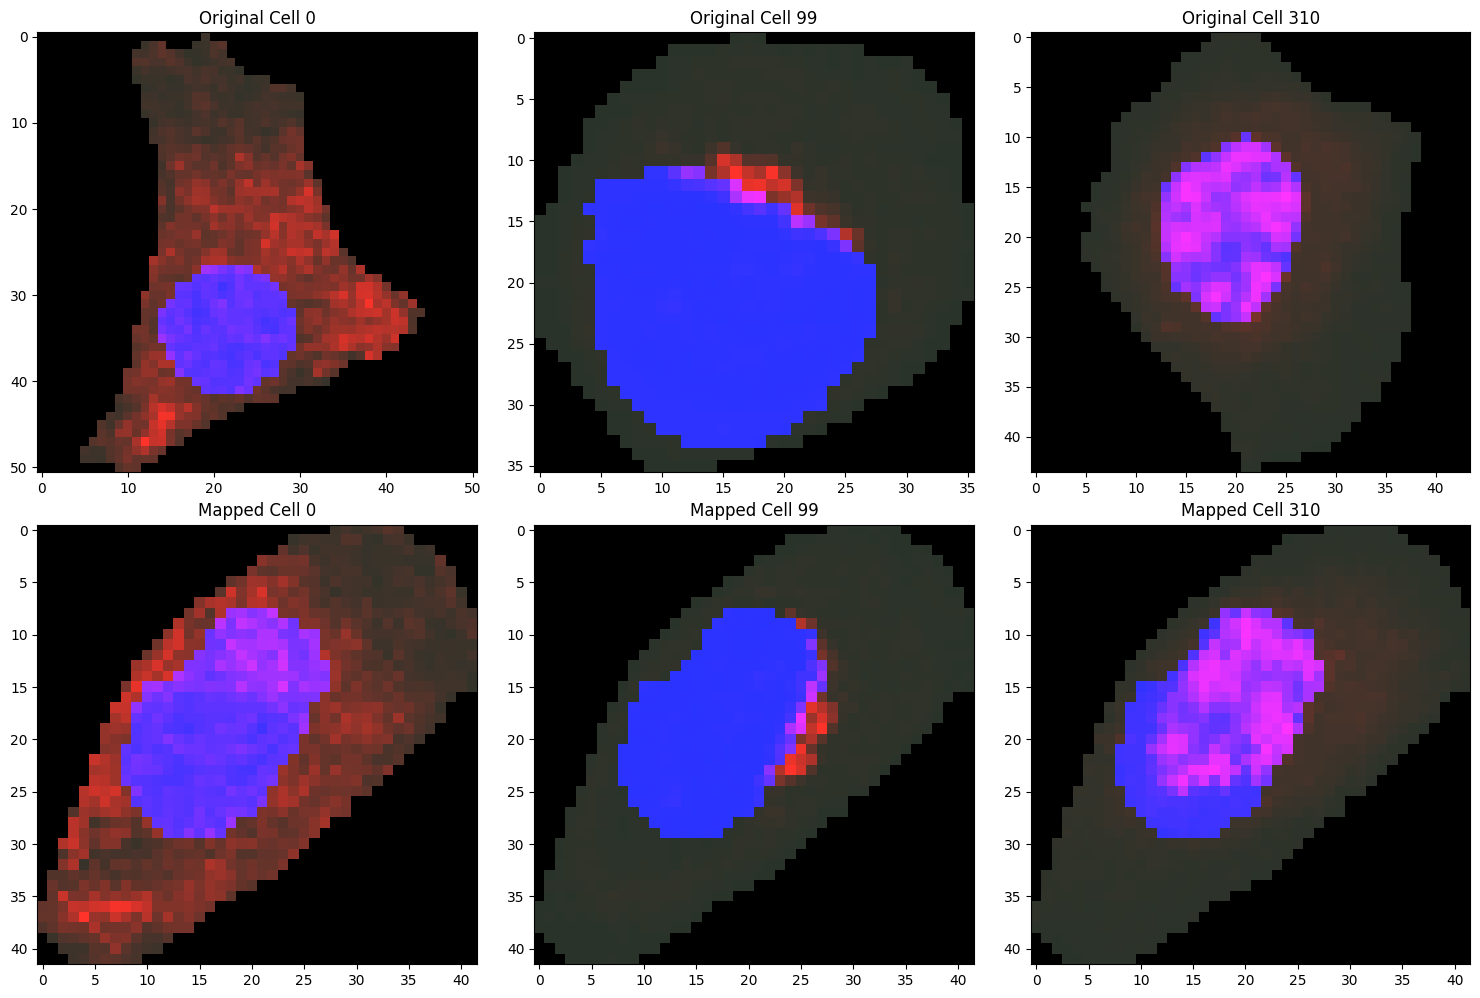

In [ ]:
cells_to_plot = [0, 99, 310]
fig, axes = plt.subplots(2, len(cells_to_plot), figsize=(15, 10))

for idx, i in enumerate(cells_to_plot):
    # Plotting original cell
    plot_cell_image(cell_objects[i], channels=['nucleus', 'protein'], ax=axes[0, idx])
    axes[0, idx].set_title(f'Original Cell {i}')
    
    # Plotting mapped cell
    mapped_cell_object = cell_objects[target_cell_ind].copy()
    for j, channel in enumerate(channels_to_map):
        mapped_cell_object.intensities[channel] = mapped_distbs[j][i]
    plot_cell_image(mapped_cell_object, channels=['nucleus', 'protein'], ax=axes[1, idx])
    axes[1, idx].set_title(f'Mapped Cell {i}')

plt.tight_layout()
plt.show()

In [ ]:
# We choose the morphological centroid cell as the anchor cell to map to
target_cell_ind = find_centroid(gw_dmat)

channels_to_map = ['protein'] # which distributions to quantify variation in localization patterns for
# Mapping all cells to anchor cell
mapped_distbs = map_to_cell_parallel(cell_objects, 
                                     channels_to_map, 
                                     target_cell_ind, # cell to map to
                                     method='fused', # 'fused' for full mapping, 'fused' for partial mapping
                                     fused_channel='nucleus', # addition info to consider for mapping
                                     fused_cost=1000, fused_param=0.1, # controls weight of additional info
                                     compartment_specific=True, # enforces strict mapping of nucleus to nucleus
                                     num_processes=cpu_count(), chunksize=1) # parallelization parameters

Mapping cells to target cell:


373it [19:59,  3.22s/it]                         


In [ ]:
mapped_distbs = map_to_cell_parallel(cell_objects[:10], 
                                     channels_to_map, 
                                     0, # cell to map to
                                     method='fused', # 'fused' for full mapping, 'fused' for partial mapping
                                     fused_channel='nucleus', # addition info to consider for mapping
                                     fused_cost=1000, fused_param=0.1, # controls weight of additional info
                                     compartment_specific=True, # enforces strict mapping of nucleus to nucleus
                                     num_processes=cpu_count(), chunksize=1) # parallelization parameters

Mapping cells to target cell:


10it [00:48,  4.82s/it]                      


We can visualize some examples of the mapped to localalization patterns to see whether the mapping parameters need adjustment.

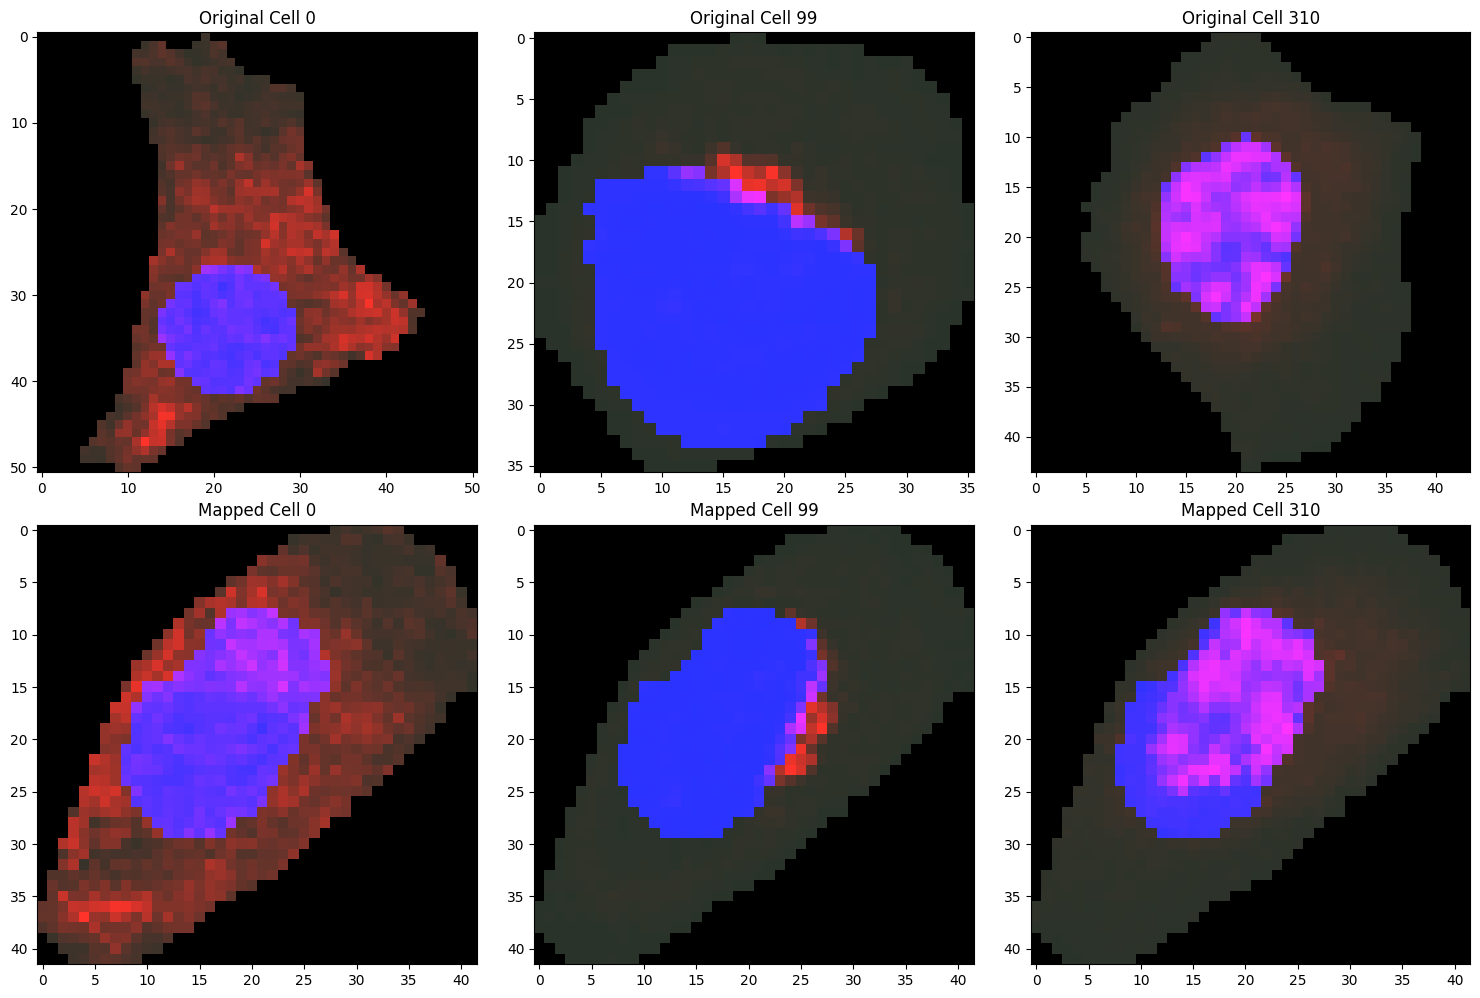

In [ ]:
cells_to_plot = [0, 99, 310]
fig, axes = plt.subplots(2, len(cells_to_plot), figsize=(15, 10))

for idx, i in enumerate(cells_to_plot):
    # Plotting original cell
    plot_cell_image(cell_objects[i], channels=['nucleus', 'protein'], ax=axes[0, idx])
    axes[0, idx].set_title(f'Original Cell {i}')
    
    # Plotting mapped cell
    mapped_cell_object = cell_objects[target_cell_ind].copy()
    for j, channel in enumerate(channels_to_map):
        mapped_cell_object.intensities[channel] = mapped_distbs[j][i]
    plot_cell_image(mapped_cell_object, channels=['nucleus', 'protein'], ax=axes[1, idx])
    axes[1, idx].set_title(f'Mapped Cell {i}')

plt.tight_layout()
plt.show()

After mapping all cells to the anchor cell, we compute the optimal transport (Wasserstein) distance to measure the difference in protein localization patterns between cells. Similar to the Gromov-Wasserstein morphology space, we can cluster cells based on the optimal transport localization space to identify groups of cells with similar protein localization patterns, and visualize the space with UMAP.

In [ ]:
ot_dmats = gw_mapped_ot_pairwise_parallel(cell_objects[target_cell_ind], mapped_distbs, num_processes=cpu_count(), chunksize=20)

Computing pairwise OT distances:


100%|██████████| 69378/69378 [20:54<00:00, 55.29it/s] 


In [4]:
import plotly.io as pio

# Choose the adequate plotly renderer for visualizing plotly graphs in your system
pio.renderers.default = 'notebook_connected'
# pio.renderers.default = 'iframe'

import cajal.utilities
import umap
import plotly.express

# Compute UMAP representation of the OT localization space
reducer = umap.UMAP(metric="precomputed", random_state=1)
embedding = reducer.fit_transform(ot_dmats[0])

# Cluster cells based on the OT localization space using the leiden algorithm
clusters = cajal.utilities.leiden_clustering(ot_dmats[0], resolution=0.005, seed=1)

# Visualize the OT localization space
plotly.express.scatter(x=embedding[:,0],
                       y=embedding[:,1],
                       template="simple_white",
                       hover_name=["cell_" + str(i) for i in range(ot_dmats[0].shape[0])],
                       color = [str(c) for c in clusters]
                       )

/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable

/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:1992: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



We can visualize some example cells and their protein distributions from cluster 0.

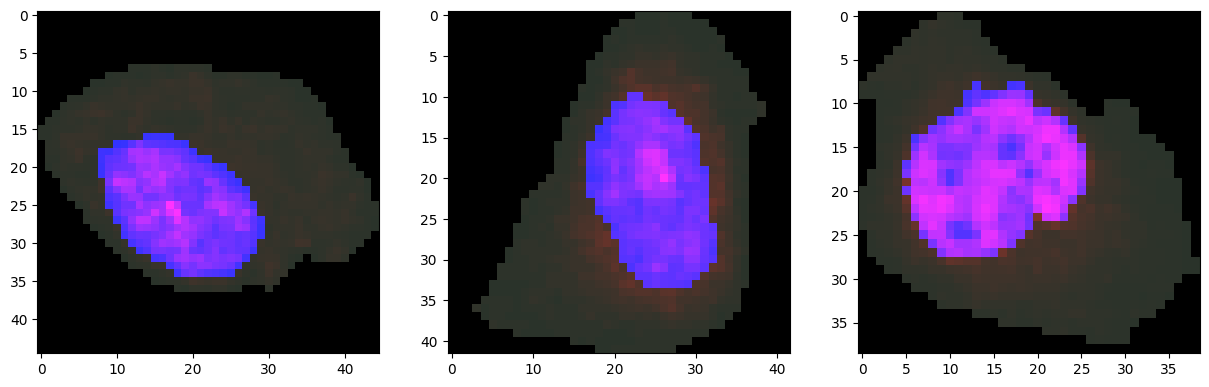

In [ ]:
cells_to_plot = [335, 270, 309] # Example cells from cluster 0
fig, axes = plt.subplots(1, len(cells_to_plot), figsize=(15, 5))
for ax, i in zip(axes, cells_to_plot):
    plot_cell_image(cell_objects[i], channels=['nucleus', 'protein'], ax=ax)
plt.show()

We can also color the UMAP representation of the optimal transport localization space by the localization pattern annotations from the Human Protein Atlas. As expected, the annotated localization patterns separate in the localization space.

In [5]:
plotly.express.scatter(x=embedding[:,0],
                       y=embedding[:,1],
                       template="simple_white",
                       hover_name=np.array(["cell_" + str(i) for i in range(ot_dmats[0].shape[0])]),
                       color = np.array([str(c) for c in cell_metadata['locations']])
                       )

/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:1992: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

